### 目的
二酸化炭素濃度の経年変化に時系列解析（SARIMA）を適用し、最近2年間の濃度変化を予測する。
データは[こちら](https://www.data.jma.go.jp/ghg/kanshi/obs/co2_monthave_ryo.html)からダウンロードした。気象庁が提供するデータである。


In [31]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [32]:
import pandas as pd

SRC_PATH = '/home/kumada/projects/cct-seiya-kumada/sarima/data/co2_monthave_ryo_concated.csv'
# Load the CSV file
data = pd.read_csv(SRC_PATH)

# Convert the 'date' column to a datetime format for better plotting
# data["date"] = pd.to_datetime(data["date"], format="%b-%y")
data["date"] = pd.to_datetime(data["date"], infer_datetime_format=True)

### 原系列の表示

Text(0, 0.5, 'CO2')

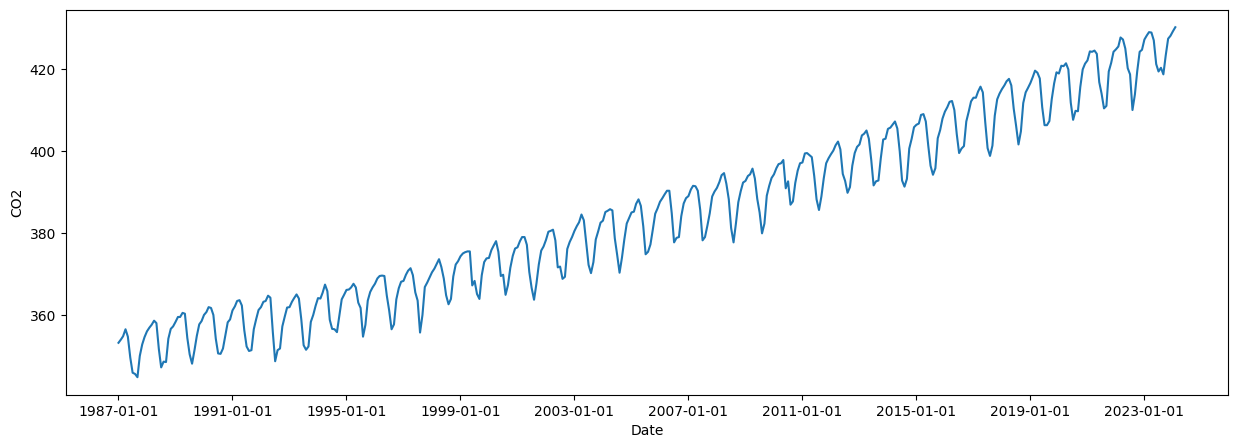

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.plot(data["date"], data['co2'])
# plot values in 12 month intervals
plt.xticks(data["date"][::4*12])
plt.xlabel('Date')
plt.ylabel('CO2')

### 原系列の自己相関を見る

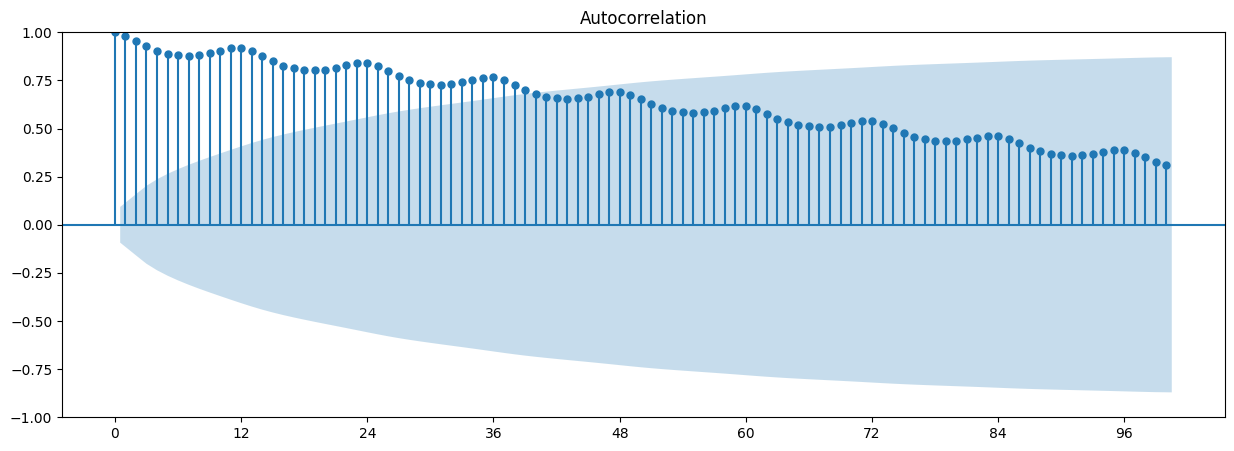

In [34]:
import statsmodels.api as sm
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(111)
ax1.set_xticks(range(0, len(data), 12))
fig = sm.graphics.tsa.plot_acf(data["co2"], lags=100, ax=ax1)
#plt.savefig("..//images//acf.png")

うねうねと波打っている様子を観察できる。周期は12であることが分かる。$m=12$

### 1階差分を取る

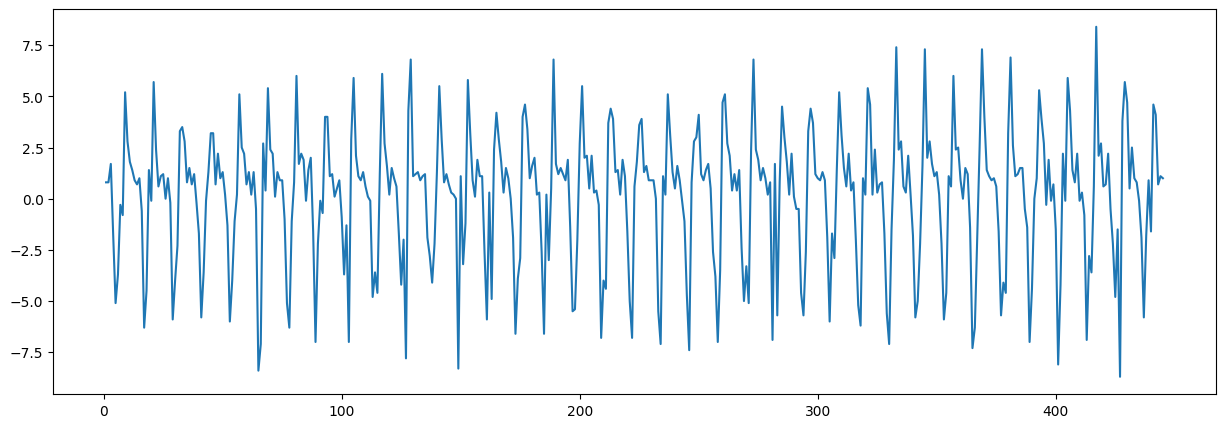

In [35]:
diff_data = data["co2"].diff(periods=1).dropna()
plt.figure(figsize=(15, 5))
plt.plot(diff_data)

- トレンドが無くなった。
- 0を中心にほぼ同じ振幅で振動している。定常過程のように見える。

### 1階差分の自己相関を見る

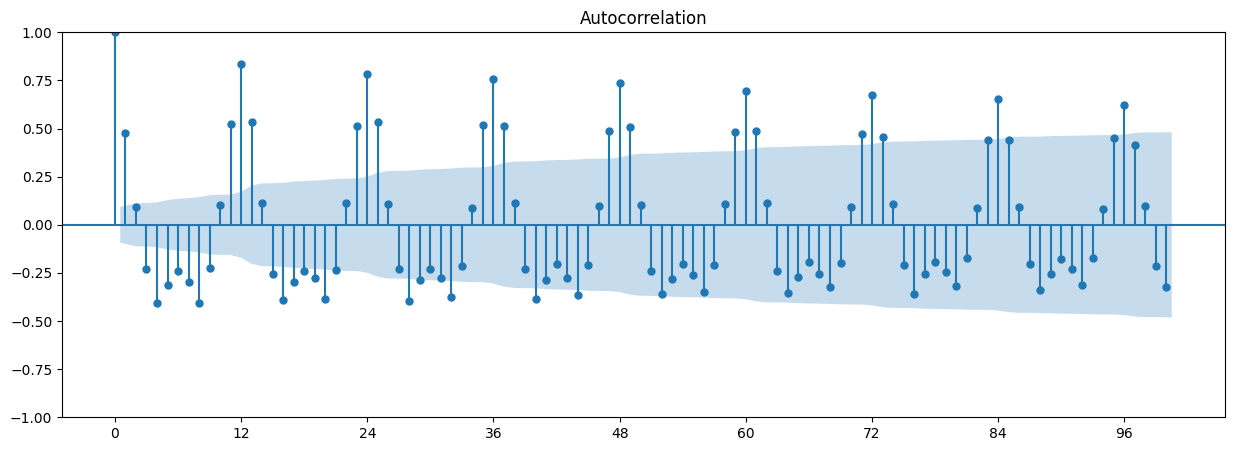

In [36]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(111)
ax1.set_xticks(range(0, len(data), 12))
fig = sm.graphics.tsa.plot_acf(diff_data, lags=100, ax=ax1)
#plt.savefig("..//images//acf_diff_1.png")

有意な相関は残っているように見えるが。。。

### 差分回数を調べる

In [37]:
import statsmodels.api as sm

# 原系列に対して
kpss_stat, p_value, lags, crit = sm.tsa.kpss(data["co2"])
print(f"kpss_stat: {kpss_stat}")
print(f"p_value: {p_value}")
print(f"lags: {lags}")
print(f"cirt: {crit}")

kpss_stat: 3.5120955974130674
p_value: 0.01
lags: 12
cirt: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


p値は0.05より小さい。単位根あり。非定常である。

In [38]:
# 1階差分系列に対して
kpss_stat, p_value, lags, crit = sm.tsa.kpss(diff_data)
print(f"kpss_stat: {kpss_stat}")
print(f"p_value: {p_value}")
print(f"lags: {lags}")
print(f"cirt: {crit}")

kpss_stat: 0.016985551996455007
p_value: 0.1
lags: 0
cirt: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


p値は0.05より大きい。単位根なし。定常である。

以上の結果から差分は一度取れば良い。

In [39]:
from pmdarima import arima

d = arima.ndiffs(data["co2"])
print(f"d: {d}")

d: 1


別の方法でも差分回数は1と出る。

### 訓練データとテストデータに分ける

In [40]:
OFFSET = 24
train = data['co2'][:-OFFSET]
test = data.iloc[-OFFSET:]

### 訓練データでパラメータ最適化

In [50]:
import utils
d = 1
m = 12
best_result = utils.execute_grid_search(train, d, m)
a = best_result[0]
A = best_result[1]
print(f"> best model(p,d,q),(P,D,Q,m),AIC: {best_result}")

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.57592D+00    |proj g|=  7.40456D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   2.737D-07   2.576D+00
  F =   2.5759232059824795     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
order(0, 1, 0), s_order(0, 0, 0, 12) - AIC: 2176.0791858492125
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.27973D+00    |proj g|=  3.12456D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7      9      1     0     0   1.040D-05   2.280D+00
  F =   2.2797275483890598     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
order(0, 1, 0), s_order(0, 0, 1, 12) - AIC: 1928.0900508403665
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.87765D+00    |proj g|=  1.86343D-02

           * * *

Tit   = total number of iterations
Tnf   = total n

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.73585D+00    |proj g|=  1.10046D-01

At iterate    5    f=  1.70071D+00    |proj g|=  4.01344D-03


 This problem is unconstrained.



At iterate   10    f=  1.70043D+00    |proj g|=  9.71578D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     10     12      1     0     0   9.716D-07   1.700D+00
  F =   1.7004304361305915     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
order(0, 1, 0), s_order(0, 1, 1, 12) - AIC: 1439.1632880942193
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.91613D+00    |proj g|=  5.64154D-03


 This problem is unconstrained.



At iterate    5    f=  1.91600D+00    |proj g|=  1.76392D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      8      1     0     0   1.764D-07   1.916D+00
  F =   1.9159967919834373     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
order(0, 1, 0), s_order(1, 0, 0, 12) - AIC: 1621.1012924340212
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.80895D+00    |proj g|=  5.07541D-02

At iterate    5    f=  1.78557D+00    |proj g|=  2.28676D-02

At ite

 This problem is unconstrained.



At iterate   15    f=  1.77142D+00    |proj g|=  1.34261D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     24      1     0     0   1.474D-05   1.771D+00
  F =   1.7714176088529960     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
order(0, 1, 0), s_order(1, 0, 1, 12) - AIC: 1501.0764618719286
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.78292D+00    |proj g|=  1.35648D-02

           * * *

Tit   = total number of iterations
Tnf   = total n

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.75908D+00    |proj g|=  6.63898D-02

At iterate    5    f=  1.68755D+00    |proj g|=  2.10454D-02


 This problem is unconstrained.



At iterate   10    f=  1.68168D+00    |proj g|=  4.84112D-03

At iterate   15    f=  1.68114D+00    |proj g|=  3.17759D-03

At iterate   20    f=  1.68109D+00    |proj g|=  2.86042D-04

At iterate   25    f=  1.68109D+00    |proj g|=  4.88459D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     35      1     0     0   5.957D-05   1.681D+00
  F =   1.6810888795065246     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
order(0, 1, 0), s_order(1, 1, 1, 12) - AIC: 1424.8390143035067
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           1

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.24606D+00    |proj g|=  1.29028D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     11      1     0     0   1.192D-06   2.246D+00
  F =   2.2460609110728034     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
order(0, 1, 1), s_order(0, 0, 1, 12) - AIC: 1901.675408945446
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.71283D+00    |proj g|=  5.89877D-02

At iterate    5    f=  1.70541D+00    |proj g|=  3.52280D-06

       

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58847D+00    |proj g|=  2.08370D-01

At iterate    5    f=  1.52288D+00    |proj g|=  4.39445D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     11      1     0     0   5.308D-06   1.523D+00
  F =   1.5227048074550140     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
order(0, 1, 1), s_order(0, 1, 1, 12) - AIC: 1291.162857492032
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate   10    f=  1.78082D+00    |proj g|=  2.15682D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     15      1     0     0   7.545D-08   1.781D+00
  F =   1.7808187599287222     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
order(0, 1, 1), s_order(1, 0, 0, 12) - AIC: 1509.0110333798416
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20268D+00    |proj g|=  2.22868D-01

At iterate    5    f=  1.69852D+00    |proj g|=  4.80702D-02


 This problem is unconstrained.



At iterate   10    f=  1.64445D+00    |proj g|=  5.67320D-02

At iterate   15    f=  1.61156D+00    |proj g|=  1.06767D-02

At iterate   20    f=  1.60836D+00    |proj g|=  3.14550D-03

At iterate   25    f=  1.60834D+00    |proj g|=  6.75934D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     41      1     0     0   6.759D-05   1.608D+00
  F =   1.6083353192546557     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
order(0, 1, 1), s_order(1, 0, 1, 12) - AIC: 1365.4350094509293
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           1

 This problem is unconstrained.


order(0, 1, 1), s_order(1, 1, 0, 12) - AIC: 1364.9408908305081
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.61066D+00    |proj g|=  1.76603D-01


 This problem is unconstrained.



At iterate    5    f=  1.51668D+00    |proj g|=  2.65778D-02

At iterate   10    f=  1.51425D+00    |proj g|=  3.64094D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     15      1     0     0   6.842D-06   1.514D+00
  F =   1.5142491433508085     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
order(0, 1, 1), s_order(1, 1, 1, 12) - AIC: 1286.0262769880824
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.43527D+00    |proj g|=  7.50056D-02

At ite

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.24169D+00    |proj g|=  7.88007D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     12      1     0     0   1.269D-06   2.242D+00
  F =   2.2416891119001425     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
order(0, 1, 2), s_order(0, 0, 1, 12) - AIC: 1899.9856104437204
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70179D+00    |proj g|=  2.13469D-02


 This problem is unconstrained.



At iterate    5    f=  1.70139D+00    |proj g|=  2.93470D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     10      1     0     0   4.202D-06   1.701D+00
  F =   1.7013921574427726     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
order(0, 1, 2), s_order(0, 1, 0, 12) - AIC: 1441.9749808817


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57371D+00    |proj g|=  2.08968D-01

At iterate    5    f=  1.51737D+00    |proj g|=  6.27797D-03

At iterate   10    f=  1.51726D+00    |proj g|=  1.47061D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   3.025D-06   1.517D+00
  F =   1.5172565365249857     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
order(0, 1, 2), s_order(0, 1, 1, 12) - AIC: 1288.564516827088
RUNNING 

 This problem is unconstrained.



At iterate    5    f=  1.78058D+00    |proj g|=  2.95581D-02

At iterate   10    f=  1.77220D+00    |proj g|=  3.33529D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     19      1     0     0   1.217D-05   1.772D+00
  F =   1.7721349200397754     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
order(0, 1, 2), s_order(1, 0, 0, 12) - AIC: 1503.6818725135704
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.19780D+00    |proj g|=  2.13654D-01


 This problem is unconstrained.



At iterate    5    f=  1.67831D+00    |proj g|=  4.30823D-02

At iterate   10    f=  1.63753D+00    |proj g|=  4.75739D-02

At iterate   15    f=  1.60356D+00    |proj g|=  1.23473D-02

At iterate   20    f=  1.59992D+00    |proj g|=  1.86507D-03

At iterate   25    f=  1.59991D+00    |proj g|=  6.79773D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     39      1     0     0   6.823D-05   1.600D+00
  F =   1.5999112887886693     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
order(0, 1, 2), s_order(1, 0, 1, 12) - AIC: 1360.3251277376369
RUNNING THE L-BFGS-B CODE

           * * *

Machi

 This problem is unconstrained.



At iterate    5    f=  1.60538D+00    |proj g|=  7.75228D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   3.745D-06   1.605D+00
  F =   1.6053764789272309     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
order(0, 1, 2), s_order(1, 1, 0, 12) - AIC: 1362.9377482145828
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.59623D+00    |proj g|=  1.76153D-01


 This problem is unconstrained.



At iterate    5    f=  1.50949D+00    |proj g|=  3.58675D-02

At iterate   10    f=  1.50843D+00    |proj g|=  1.46164D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     16      1     0     0   1.297D-06   1.508D+00
  F =   1.5084333492290218     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
order(0, 1, 2), s_order(1, 1, 1, 12) - AIC: 1283.1177467492944
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.44054D+00    |proj g|=  9.43120D-04

      

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.24398D+00    |proj g|=  8.09588D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     10      1     0     0   1.244D-07   2.244D+00
  F =   2.2439828392691181     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
order(1, 1, 0), s_order(0, 0, 1, 12) - AIC: 1899.9215163431359
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.79327D+00    |proj g|=  1.53430D-03

           * * *

Tit   = total number of iterations
Tnf   = total n

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.61380D+00    |proj g|=  7.45400D-03

At iterate   10    f=  1.61347D+00    |proj g|=  1.26075D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     12      1     0     0   1.261D-06   1.613D+00
  F =   1.6134714153036644     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
order(1, 1, 0), s_order(0, 1, 1, 12) - AIC: 1367.7698745162927
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.22183D+00    |proj g|=  1.80240D-01


 This problem is unconstrained.



At iterate    5    f=  1.85837D+00    |proj g|=  2.46777D-02

At iterate   10    f=  1.85335D+00    |proj g|=  5.00442D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     16      1     0     0   5.730D-07   1.853D+00
  F =   1.8533474884841030     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
order(1, 1, 0), s_order(1, 0, 0, 12) - AIC: 1570.2252802805829
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16514D+00    |proj g|=  2.09586D-01


 This problem is unconstrained.



At iterate    5    f=  1.74633D+00    |proj g|=  2.81466D-02

At iterate   10    f=  1.70558D+00    |proj g|=  1.70402D-02

At iterate   15    f=  1.69243D+00    |proj g|=  5.04452D-03

At iterate   20    f=  1.69193D+00    |proj g|=  1.96597D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     27      1     0     0   6.731D-06   1.692D+00
  F =   1.6919324208885993     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
order(1, 1, 0), s_order(1, 0, 1, 12) - AIC: 1435.9909632299778
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           1

 This problem is unconstrained.



At iterate    5    f=  1.69886D+00    |proj g|=  1.46996D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      8      1     0     0   1.470D-05   1.699D+00
  F =   1.6988649959129318     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
order(1, 1, 0), s_order(1, 1, 0, 12) - AIC: 1439.8420565505144
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.68616D+00    |proj g|=  1.46223D-01


 This problem is unconstrained.



At iterate    5    f=  1.60112D+00    |proj g|=  1.11964D-02

At iterate   10    f=  1.59903D+00    |proj g|=  4.17419D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     17      1     0     0   6.000D-05   1.599D+00
  F =   1.5990263236917444     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
order(1, 1, 0), s_order(1, 1, 1, 12) - AIC: 1357.5782171958322
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.43186D+00    |proj g|=  2.37035D-02

At ite

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.29648D+00    |proj g|=  1.04993D-01


 This problem is unconstrained.



At iterate    5    f=  2.24359D+00    |proj g|=  4.68324D-03

At iterate   10    f=  2.24348D+00    |proj g|=  2.88414D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   2.884D-06   2.243D+00
  F =   2.2434785518409659     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
order(1, 1, 1), s_order(0, 0, 1, 12) - AIC: 1901.4958977537754
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70507D+00    |proj g|=  4.98622D-02

At ite

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58073D+00    |proj g|=  2.15291D-01


 This problem is unconstrained.



At iterate    5    f=  1.51811D+00    |proj g|=  1.17824D-02

At iterate   10    f=  1.51766D+00    |proj g|=  3.19704D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   1.042D-05   1.518D+00
  F =   1.5176576503729193     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
order(1, 1, 1), s_order(0, 1, 1, 12) - AIC: 1288.903056914744
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.23484D+00    |proj g|=  3.04252D-01

At iter

 This problem is unconstrained.



At iterate   15    f=  1.76994D+00    |proj g|=  1.65881D-03

At iterate   20    f=  1.76988D+00    |proj g|=  9.31515D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     23      1     0     0   9.315D-06   1.770D+00
  F =   1.7698759967726405     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
order(1, 1, 1), s_order(1, 0, 0, 12) - AIC: 1501.7753412761085
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.17550D+00    |proj g|=  2.42029D-01

At ite

 This problem is unconstrained.



At iterate   10    f=  1.64135D+00    |proj g|=  3.42069D-02

At iterate   15    f=  1.61583D+00    |proj g|=  5.42029D-02

At iterate   20    f=  1.60034D+00    |proj g|=  9.34581D-03

At iterate   25    f=  1.59992D+00    |proj g|=  6.47216D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     34      1     0     0   6.573D-05   1.600D+00
  F =   1.5999215224514576     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
order(1, 1, 1), s_order(1, 0, 1, 12) - AIC: 1360.3337649490302
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           1

 This problem is unconstrained.



At iterate    5    f=  1.60647D+00    |proj g|=  1.05207D-02

At iterate   10    f=  1.60599D+00    |proj g|=  2.54389D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   7.977D-07   1.606D+00
  F =   1.6059909131354388     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
order(1, 1, 1), s_order(1, 1, 0, 12) - AIC: 1363.4563306863104
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.60252D+00    |proj g|=  1.83961D-01


 This problem is unconstrained.



At iterate    5    f=  1.50989D+00    |proj g|=  2.69234D-02

At iterate   10    f=  1.50879D+00    |proj g|=  7.45080D-04

At iterate   15    f=  1.50878D+00    |proj g|=  3.90521D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     18      1     0     0   3.905D-06   1.509D+00
  F =   1.5087796163956773     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
order(1, 1, 1), s_order(1, 1, 1, 12) - AIC: 1283.4099962379516
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At ite

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.30097D+00    |proj g|=  9.93475D-02


 This problem is unconstrained.



At iterate    5    f=  2.20342D+00    |proj g|=  5.82791D-02

At iterate   10    f=  2.19535D+00    |proj g|=  3.25426D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     14      1     0     0   2.046D-06   2.195D+00
  F =   2.1953520206590071     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
order(1, 1, 2), s_order(0, 0, 1, 12) - AIC: 1862.8771054362019
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.69810D+00    |proj g|=  1.57877D-02


 This problem is unconstrained.



At iterate    5    f=  1.69754D+00    |proj g|=  5.63594D-03

At iterate   10    f=  1.69352D+00    |proj g|=  1.62791D-02

At iterate   15    f=  1.68486D+00    |proj g|=  3.32250D-03

At iterate   20    f=  1.68379D+00    |proj g|=  2.22782D-03

At iterate   25    f=  1.68366D+00    |proj g|=  1.82674D-04

At iterate   30    f=  1.68364D+00    |proj g|=  8.25189D-05

At iterate   35    f=  1.68364D+00    |proj g|=  7.04738D-05

At iterate   40    f=  1.68364D+00    |proj g|=  4.94914D-05

At iterate   45    f=  1.68364D+00    |proj g|=  5.29577D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     45     71   

 This problem is unconstrained.



At iterate    5    f=  1.51569D+00    |proj g|=  2.14571D-03

At iterate   10    f=  1.51548D+00    |proj g|=  6.28923D-03

At iterate   15    f=  1.51546D+00    |proj g|=  1.13420D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     18      1     0     0   1.134D-05   1.515D+00
  F =   1.5154631576542281     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
order(1, 1, 2), s_order(0, 1, 1, 12) - AIC: 1289.0509050601686
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At ite

 This problem is unconstrained.



At iterate   10    f=  1.76939D+00    |proj g|=  8.57977D-03

At iterate   15    f=  1.76381D+00    |proj g|=  1.22810D-02

At iterate   20    f=  1.75784D+00    |proj g|=  2.27872D-03

At iterate   25    f=  1.75776D+00    |proj g|=  2.34884D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     37      1     0     0   1.951D-05   1.758D+00
  F =   1.7577634014401182     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
order(1, 1, 2), s_order(1, 0, 0, 12) - AIC: 1493.5523108154598
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           1

 This problem is unconstrained.



At iterate    5    f=  1.68422D+00    |proj g|=  7.02656D-02

At iterate   10    f=  1.65766D+00    |proj g|=  3.74648D-02

At iterate   15    f=  1.60671D+00    |proj g|=  3.36679D-02

At iterate   20    f=  1.59881D+00    |proj g|=  5.52225D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     31      1     0     0   5.683D-03   1.599D+00
  F =   1.5988063758079314     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
order(1, 1, 2), s_order(1, 0, 1, 12) - AIC: 1361.392581181894
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  1.60373D+00    |proj g|=  9.25589D-04

At iterate   10    f=  1.60348D+00    |proj g|=  2.07349D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     19      1     0     0   5.131D-05   1.603D+00
  F =   1.6034745255755949     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
order(1, 1, 2), s_order(1, 1, 0, 12) - AIC: 1363.332499585802
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.59339D+00    |proj g|=  1.70539D-01


 This problem is unconstrained.



At iterate    5    f=  1.50866D+00    |proj g|=  3.32749D-02

At iterate   10    f=  1.50668D+00    |proj g|=  8.71414D-04

At iterate   15    f=  1.50662D+00    |proj g|=  8.37279D-04

At iterate   20    f=  1.50662D+00    |proj g|=  9.87155D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     24      1     0     0   9.872D-06   1.507D+00
  F =   1.5066166812772899     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
order(1, 1, 2), s_order(1, 1, 1, 12) - AIC: 1283.5844789980326
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           1

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.29621D+00    |proj g|=  9.90322D-02


 This problem is unconstrained.



At iterate    5    f=  2.24296D+00    |proj g|=  1.73218D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     10      1     0     0   5.543D-06   2.243D+00
  F =   2.2429551919786150     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
order(2, 1, 0), s_order(0, 0, 1, 12) - AIC: 1901.054182029951
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.72449D+00    |proj g|=  3.29592D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      7      1     0     0   5.580D-06   1.724D+00
  F =   1.7244822831203834     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
order(2, 1, 0), s_order(0, 1, 0, 12) - AIC: 1461.4630469536037


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.59852D+00    |proj g|=  1.85839D-01

At iterate    5    f=  1.55167D+00    |proj g|=  2.02941D-02

At iterate   10    f=  1.55139D+00    |proj g|=  5.48717D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   5.487D-06   1.551D+00
  F =   1.5513932714089962     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
order(2, 1, 0), s_order(0, 1, 1, 12) - AIC: 1317.3759210691928
RUNNING

 This problem is unconstrained.



At iterate    5    f=  1.82310D+00    |proj g|=  6.77222D-02

At iterate   10    f=  1.79739D+00    |proj g|=  1.91832D-03

At iterate   15    f=  1.79727D+00    |proj g|=  1.67837D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     20      1     0     0   1.678D-06   1.797D+00
  F =   1.7972684903060552     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
order(2, 1, 0), s_order(1, 0, 0, 12) - AIC: 1524.8946058183105
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At ite

 This problem is unconstrained.



At iterate    5    f=  1.71093D+00    |proj g|=  3.86570D-02

At iterate   10    f=  1.66142D+00    |proj g|=  3.44882D-02

At iterate   15    f=  1.64161D+00    |proj g|=  2.77307D-02

At iterate   20    f=  1.63532D+00    |proj g|=  3.35125D-03

At iterate   25    f=  1.63527D+00    |proj g|=  2.25846D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     33      1     0     0   2.258D-05   1.635D+00
  F =   1.6352662475040383     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
order(2, 1, 0), s_order(1, 0, 1, 12) - AIC: 1390.1647128934083
RUNNING THE L-BFGS-B CODE

           * * *

Machi

 This problem is unconstrained.



At iterate    5    f=  1.63572D+00    |proj g|=  1.33133D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      9      1     0     0   3.811D-07   1.636D+00
  F =   1.6357203858798783     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
order(2, 1, 0), s_order(1, 1, 0, 12) - AIC: 1388.5480056826173
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.62310D+00    |proj g|=  1.50511D-01


 This problem is unconstrained.



At iterate    5    f=  1.54155D+00    |proj g|=  4.32533D-02

At iterate   10    f=  1.53868D+00    |proj g|=  1.55778D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     15      1     0     0   3.284D-06   1.539D+00
  F =   1.5386835328756470     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
order(2, 1, 0), s_order(1, 1, 1, 12) - AIC: 1308.648901747046
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.61564D+00    |proj g|=  7.07759D-01

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.33218D+00    |proj g|=  3.16581D-01


 This problem is unconstrained.



At iterate    5    f=  2.24367D+00    |proj g|=  3.30356D-03

At iterate   10    f=  2.21233D+00    |proj g|=  7.47731D-02

At iterate   15    f=  2.15697D+00    |proj g|=  3.24915D-02

At iterate   20    f=  2.15118D+00    |proj g|=  2.54604D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     39      1     0     0   5.558D-06   2.151D+00
  F =   2.1511793367173415     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
order(2, 1, 1), s_order(0, 0, 1, 12) - AIC: 1825.5953601894362
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           1

 This problem is unconstrained.



At iterate    5    f=  1.70040D+00    |proj g|=  1.53794D-02

At iterate   10    f=  1.70018D+00    |proj g|=  1.27491D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     21      1     0     0   1.275D-05   1.700D+00
  F =   1.7001802758092477     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
order(2, 1, 1), s_order(0, 1, 0, 12) - AIC: 1442.952152783005
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58044D+00    |proj g|=  1.99746D-01


 This problem is unconstrained.



At iterate    5    f=  1.51926D+00    |proj g|=  1.32581D-02

At iterate   10    f=  1.51747D+00    |proj g|=  9.25465D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     15      1     0     0   7.928D-06   1.517D+00
  F =   1.5174715741972640     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
order(2, 1, 1), s_order(0, 1, 1, 12) - AIC: 1290.7460086224908
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.09607D+00    |proj g|=  2.36056D-01

At ite

 This problem is unconstrained.



At iterate   10    f=  1.77445D+00    |proj g|=  6.91986D-03

At iterate   15    f=  1.77113D+00    |proj g|=  2.13348D-02

At iterate   20    f=  1.76611D+00    |proj g|=  5.04443D-04

At iterate   25    f=  1.76611D+00    |proj g|=  4.96831D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     32      1     0     0   6.451D-07   1.766D+00
  F =   1.7661090324705901     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
order(2, 1, 1), s_order(1, 0, 0, 12) - AIC: 1500.5960234051781
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           1

 This problem is unconstrained.



At iterate    5    f=  1.70373D+00    |proj g|=  3.64050D-02

At iterate   10    f=  1.62508D+00    |proj g|=  6.37804D-02

At iterate   15    f=  1.61608D+00    |proj g|=  3.72922D-02

At iterate   20    f=  1.61086D+00    |proj g|=  2.95157D-02

At iterate   25    f=  1.60012D+00    |proj g|=  5.96849D-03

At iterate   30    f=  1.59988D+00    |proj g|=  1.81974D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     49      1     0     0   3.630D-05   1.600D+00
  F =   1.5998835960009719     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
order(2, 1, 1), s_order(1, 0, 1, 12) - AIC: 1362.30

 This problem is unconstrained.



At iterate    5    f=  1.60567D+00    |proj g|=  1.23115D-02

At iterate   10    f=  1.60503D+00    |proj g|=  1.38400D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     16      1     0     0   6.927D-06   1.605D+00
  F =   1.6050305251972956     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
order(2, 1, 1), s_order(1, 1, 0, 12) - AIC: 1364.6457632665174
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.60388D+00    |proj g|=  1.65663D-01


 This problem is unconstrained.



At iterate    5    f=  1.51249D+00    |proj g|=  5.68971D-02

At iterate   10    f=  1.50926D+00    |proj g|=  4.61448D-03

At iterate   15    f=  1.50873D+00    |proj g|=  7.79298D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     20      1     0     0   5.966D-07   1.509D+00
  F =   1.5087276191264158     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
order(2, 1, 1), s_order(1, 1, 1, 12) - AIC: 1285.366110542695
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   20    f=  2.15922D+00    |proj g|=  3.09027D-02

At iterate   25    f=  2.15830D+00    |proj g|=  1.18026D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     35      1     0     0   1.007D-05   2.158D+00
  F =   2.1582992974103576     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
order(2, 1, 2), s_order(0, 0, 0, 12) - AIC: 1831.604607014342
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.24239D+00    |proj g|=  1.10514D-01


 This problem is unconstrained.



At iterate    5    f=  2.14533D+00    |proj g|=  4.78058D-02

At iterate   10    f=  2.03610D+00    |proj g|=  1.48922D-01

At iterate   15    f=  2.01114D+00    |proj g|=  6.42279D-02

At iterate   20    f=  2.00652D+00    |proj g|=  2.73660D-03

At iterate   25    f=  2.00645D+00    |proj g|=  3.63138D-03

At iterate   30    f=  2.00643D+00    |proj g|=  8.02634D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     35      1     0     0   8.026D-06   2.006D+00
  F =   2.0064264184911913     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
order(2, 1, 2), s_order(0, 0, 1, 12) - AIC: 1705.42

 This problem is unconstrained.



At iterate   10    f=  1.69124D+00    |proj g|=  5.18563D-02

At iterate   15    f=  1.68733D+00    |proj g|=  2.70716D-02

At iterate   20    f=  1.68362D+00    |proj g|=  9.29999D-03

At iterate   25    f=  1.68316D+00    |proj g|=  3.07581D-03

At iterate   30    f=  1.68311D+00    |proj g|=  9.22885D-04

At iterate   35    f=  1.68310D+00    |proj g|=  7.35075D-05

At iterate   40    f=  1.68310D+00    |proj g|=  7.40465D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     52      1     0     0   7.405D-05   1.683D+00
  F =   1.6831012855035834     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  1.51561D+00    |proj g|=  6.35057D-03

At iterate   10    f=  1.51545D+00    |proj g|=  7.98145D-04

At iterate   15    f=  1.51534D+00    |proj g|=  1.63988D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     22      1     0     0   1.449D-05   1.515D+00
  F =   1.5153338678993853     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
order(2, 1, 2), s_order(0, 1, 1, 12) - AIC: 1290.9417845070811
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At ite

 This problem is unconstrained.



At iterate    5    f=  1.82534D+00    |proj g|=  7.76115D-02

At iterate   10    f=  1.76891D+00    |proj g|=  3.95956D-03

At iterate   15    f=  1.76689D+00    |proj g|=  6.26128D-03

At iterate   20    f=  1.76137D+00    |proj g|=  2.30117D-02

At iterate   25    f=  1.75707D+00    |proj g|=  3.17063D-03

At iterate   30    f=  1.75704D+00    |proj g|=  9.38974D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     37      1     0     0   2.849D-05   1.757D+00
  F =   1.7570445211031345     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
order(2, 1, 2), s_order(1, 0, 0, 12) - AIC: 1494.94

 This problem is unconstrained.



At iterate    5    f=  1.73091D+00    |proj g|=  5.39109D-02

At iterate   10    f=  1.65029D+00    |proj g|=  3.13630D-02

At iterate   15    f=  1.63260D+00    |proj g|=  5.28453D-02

At iterate   20    f=  1.60196D+00    |proj g|=  2.59803D-02

At iterate   25    f=  1.59772D+00    |proj g|=  8.15230D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26     39      1     0     0   8.886D-04   1.598D+00
  F =   1.5977151768730331     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
order(2, 1, 2), s_order(1, 0, 1, 12) - AIC: 1362.4716092808399
RUNNING THE L-BFGS-B CODE

           * * *

Machi


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.60346D+00    |proj g|=  1.64801D-03

At iterate   10    f=  1.60346D+00    |proj g|=  3.02369D-04

At iterate   15    f=  1.60345D+00    |proj g|=  7.14606D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     15     20      1     0     0   7.146D-06   1.603D+00
  F =   1.6034544233428447     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
order(2, 1, 2), s_order(1, 1, 0, 12) - AIC: 1365.315533301361
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  1.50846D+00    |proj g|=  2.03946D-02

At iterate   10    f=  1.50663D+00    |proj g|=  1.65754D-03

At iterate   15    f=  1.50651D+00    |proj g|=  4.44508D-03

At iterate   20    f=  1.50634D+00    |proj g|=  2.82331D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     23     26      1     0     0   4.949D-06   1.506D+00
  F =   1.5063372020290848     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
order(2, 1, 2), s_order(1, 1, 1, 12) - AIC: 1285.3485985125476
> best model(p,d,q),(P,D,Q,m),AIC: [(0, 1, 2), (1, 1, 1, 12), 1283.1177467492944]


In [42]:
print(a)
print(A)

(0, 1, 2)
(1, 1, 1, 12)


### 訓練

In [43]:
model = utils.train(train, a, A)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.59623D+00    |proj g|=  1.76153D-01


 This problem is unconstrained.



At iterate    5    f=  1.50949D+00    |proj g|=  3.58675D-02

At iterate   10    f=  1.50843D+00    |proj g|=  1.46164D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     16      1     0     0   1.297D-06   1.508D+00
  F =   1.5084333492290218     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


### 予測


In [44]:
train_pred, test_pred, test_pred_ci = utils.predict(model, test['co2'])

In [45]:
test_pred

422    426.611772
423    427.140811
424    425.850023
425    419.492316
426    415.459371
427    413.409208
428    414.733215
429    421.293800
430    424.203278
431    426.198137
432    427.009045
433    428.125308
434    429.013456
435    429.518520
436    428.144845
437    421.878723
438    417.637551
439    415.849134
440    417.295416
441    423.545349
442    426.591537
443    428.467307
444    429.313834
445    430.500398
Name: predicted_mean, dtype: float64

In [46]:
test['co2']

422    427.8
423    427.3
424    425.1
425    420.3
426    418.8
427    410.1
428    413.9
429    419.6
430    424.3
431    424.8
432    427.3
433    428.3
434    429.1
435    429.0
436    427.1
437    421.3
438    419.5
439    420.4
440    418.8
441    423.4
442    427.5
443    428.2
444    429.3
445    430.3
Name: co2, dtype: float64

In [47]:
guideline = data.iloc[-2*OFFSET:]

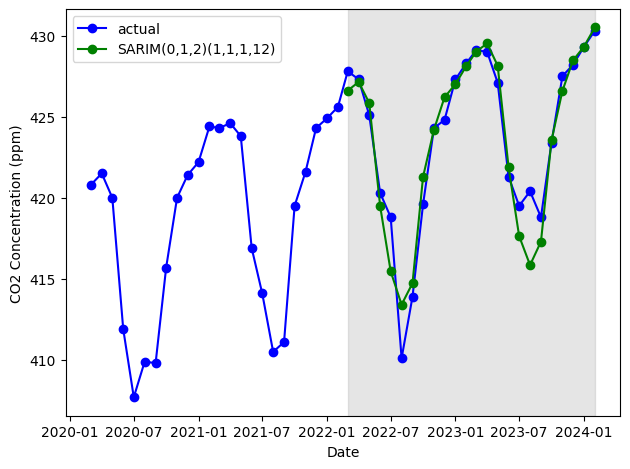

In [49]:
fig, ax = plt.subplots()

ax.plot(guideline["date"], guideline['co2'], 'b-', label='actual', marker='o')
ax.plot(test['date'], test_pred, 'g-', label='SARIM(0,1,2)(1,1,1,12)', marker='o')

ax.axvspan(test['date'].iloc[0], test['date'].iloc[-1], color='#808080', alpha=0.2)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Concentration (ppm)')
ax.legend(loc='best')
fig.autofmt_xdate
plt.tight_layout()